In [1]:
# importing libraries
import pandas as pd
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import plotly.express as px
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# reading and validate the data
confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv').groupby('Country/Region', as_index=False).sum()
death = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv').groupby('Country/Region', as_index=False).sum()
recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv').groupby('Country/Region', as_index=False).sum()
reported_countries = len(confirmed['Country/Region'])
print(confirmed['Country/Region'].isin(death['Country/Region']).value_counts())
print(confirmed['Country/Region'].isin(recovered['Country/Region']).value_counts())

True    188
Name: Country/Region, dtype: int64
True    188
Name: Country/Region, dtype: int64


In [3]:
# transform data into daily report
confirmed_daily = confirmed.drop(['Lat','Long'],1).transpose().reset_index()
confirmed_daily = pd.DataFrame(confirmed_daily.values[1:], columns=confirmed_daily.iloc[0,:])
confirmed_daily['Global'] = confirmed_daily.iloc[:,1:].sum(axis=1)
confirmed_daily = confirmed_daily.rename(columns={'Country/Region':'Date'})
death_daily = death.drop(['Lat','Long'],1).transpose().reset_index()
death_daily = pd.DataFrame(death_daily.values[1:], columns=death_daily.iloc[0,:])
death_daily['Global'] = death_daily.iloc[:,1:].sum(axis=1)
death_daily = death_daily.rename(columns={'Country/Region':'Date'})
recovered_daily = recovered.drop(['Lat','Long'],1).transpose().reset_index()
recovered_daily = pd.DataFrame(recovered_daily.values[1:], columns=recovered_daily.iloc[0,:])
recovered_daily['Global'] = recovered_daily.iloc[:,1:].sum(axis=1)
recovered_daily = recovered_daily.rename(columns={'Country/Region':'Date'})

In [4]:
# transform & join data into cumulative cases by countries table
table = confirmed[['Country/Region','Long','Lat']]
table['ConfirmedCases'] = confirmed.iloc[:,-1]
table['NewConfirmedCases'] = confirmed.iloc[:,-1] - confirmed.iloc[:,-2]
table['DeathCases'] = death.iloc[:,-1]
table['NewDeathCases'] = death.iloc[:,-1] - death.iloc[:,-2]
table['RecoveredCases'] = recovered.iloc[:,-1]
table['NewRecoveredCases'] = recovered.iloc[:,-1] - recovered.iloc[:,-2]
table = table.fillna(0)
table['ActiveCases'] = table['ConfirmedCases'] - table['DeathCases'] - table['RecoveredCases']
table['NewActiveCases'] = table['NewConfirmedCases'] - table['NewDeathCases'] - table['NewRecoveredCases']
table = table.sort_values(by='Country/Region')
table
# aggregate table by case category, for dashboard development
confirmed_table = table[['ConfirmedCases','Country/Region']].groupby('Country/Region', as_index=False).agg({"ConfirmedCases": "sum"})
death_table = table[['DeathCases','Country/Region']].groupby('Country/Region', as_index=False).agg({"DeathCases": "sum"})
recovered_table = table[['RecoveredCases','Country/Region']].groupby('Country/Region', as_index=False).agg({"RecoveredCases": "sum"})

In [5]:
# summary and score cards value
active_total = table['ActiveCases'].sum()
active_new_total = table['NewActiveCases'].sum()
confirmed_total = table['ConfirmedCases'].sum()
confirmed_new_total = table['NewConfirmedCases'].sum()
death_total = table['DeathCases'].sum()
death_new_total = table['NewDeathCases'].sum()
recovered_total = table['RecoveredCases'].sum()
recovered_new_total = table['NewRecoveredCases'].sum()
summary_total = {'Cases':['Active','Confirmed','Death','Recovered'],'Total':[f'{active_total:,}',f'{confirmed_total:,}',f'{death_total:,}',f'{recovered_total:,}'],'New':[f'{active_new_total:,}',f'{confirmed_new_total:,}',f'{death_new_total:,}',f'{recovered_new_total:,}']}
summary_total = pd.DataFrame(summary_total, columns = ['Cases','Total','New'])
summary_total

,Cases,Total,New
0,Active,"2,770,891","35,679"
1,Confirmed,"4,996,472","98,980"
2,Death,"328,115","4,830"
3,Recovered,"1,897,466","58,471"


In [6]:
# scatter mapbox for confirmed cases
c_fig = px.scatter_mapbox(table, lat="Lat", lon="Long", hover_name="Country/Region", hover_data=["ConfirmedCases"],
                        color_discrete_sequence=["fuchsia"], zoom=0.5, width=900, height=500, color="ConfirmedCases", size="ConfirmedCases")
c_fig.update_layout(mapbox_style="open-street-map")
c_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
c_fig.show()

In [7]:
# scatter mapbox for death cases
d_fig = px.scatter_mapbox(table, lat="Lat", lon="Long", hover_name="Country/Region", hover_data=["DeathCases"],
                        color_discrete_sequence=["fuchsia"], zoom=0.5, width=900, height=500, color="DeathCases", size="DeathCases")
d_fig.update_layout(mapbox_style="open-street-map")
d_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
d_fig.show()

In [8]:
# scatter mapbox for recovered cases
r_fig = px.scatter_mapbox(table, lat="Lat", lon="Long", hover_name="Country/Region", hover_data=["RecoveredCases"],
                        color_discrete_sequence=["fuchsia"], zoom=0.5, width=900, height=500, color="RecoveredCases", size="RecoveredCases")
r_fig.update_layout(mapbox_style="open-street-map")
r_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
r_fig.show()    

In [9]:
# timeseries data (new cases daily)
a = pd.melt(confirmed_daily, id_vars='Date')
a['Cases'] = 'Confirmed'
b = pd.melt(death_daily, id_vars='Date')
b['Cases'] = 'Death'
c = pd.melt(recovered_daily, id_vars='Date')
c['Cases'] = 'Recovered'
daily = [a,b,c]
daily = pd.concat(daily)
daily['Date'] = pd.to_datetime(daily['Date'])
daily.columns = ['Date','Country/Region','NumberOfCases','Category']
daily['NumberOfCases'] = daily['NumberOfCases'].astype(int)
daily['NewCases'] = (daily['NumberOfCases'] - daily['NumberOfCases'].shift(1)).fillna(method='bfill')

In [10]:
# trajectory function
def cum_cases(country):
    dfc = daily[daily['Country/Region'] == country]
    fig = px.line(dfc, x="Date", y='NumberOfCases', color='Category', title=country+' Cumulative Cases')
    return fig.show()
def new_cases(country):
    dfc = daily[daily['Country/Region'] == country]
    dfc = dfc[dfc['Category'] == 'Confirmed']
    fig = px.bar(dfc, x="Date", y='NewCases', title=country+' New Cases')
    return fig.show()

In [11]:
# trajectory graph
cum_cases('Global')
new_cases('Global')

In [12]:
# data preparation for forcasting
def data_prep(country):
    dfc = daily[daily['Country/Region'] == country]
    dfx = dfc[dfc['Category'] == 'Confirmed']
    dfn = dfx.drop(['Country/Region','Category'],1)
    dfn = dfn.set_index(['Date'])
    dfn.index.name = None
    dfn.iloc[0,1] = 0
    return dfn

In [13]:
# defining logistic function
def f(X, c, k, m):    
    y = c / (1 + np.exp(-k*(X-m)))    
    return y

In [14]:
# curve fitting
def fit(country):
    dfn = data_prep(country)
    ## find optimal parameters
    model, cov = curve_fit(f=f, xdata=np.arange(len(dfn["NumberOfCases"])), ydata=dfn["NumberOfCases"].values, maxfev=10000, p0=[np.max(dfn["NumberOfCases"]), 1, 1])
    return model

In [15]:
# date as index generation
def indexdate(start, end=None, n=30, freq="D"):
    if end is not None:
        index = pd.date_range(start=start, end=end, freq=freq)
    else:
        index = pd.date_range(start=start, periods=n, freq=freq)
    index = index[1:]
    # print("--- generating index date --> start:", index[0], "| end:", index[-1], "| len:", len(index), "---")
    return index

In [16]:
# plotting the forecast
def plot(dfn, country, zoom=30, figsize=(15,5)):
    ## interval
    dfn["residuals"] = dfn["ts"] - dfn["model"]
    dfn["conf_int_low"] = dfn["forecast"] - 1.96*dfn["residuals"].std()
    dfn["conf_int_up"] = dfn["forecast"] + 1.96*dfn["residuals"].std()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    plt.suptitle(country+"'s COVID-19 Outbreak Forecasting to Date")
    
    ## entire series
    dfn["ts"].plot(marker=".", linestyle='None', ax=ax[0], title="Parametric Fitting", color="black")
    dfn["model"].plot(ax=ax[0], color="green", label="model", legend=True)
    dfn["forecast"].plot(ax=ax[0], grid=True, color="red", label="forecast", legend=True)
    ax[0].fill_between(x=dfn.index, y1=dfn['conf_int_low'], y2=dfn['conf_int_up'], color='b', alpha=0.3)
   
    ## focus on last
    first_idx = dfn[pd.notnull(dfn["forecast"])].index[0]
    first_loc = dfn.index.tolist().index(first_idx)
    zoom_idx = dfn.index[first_loc-zoom]
    dfn.loc[zoom_idx:]["ts"].plot(marker=".", linestyle='None', ax=ax[1], color="black", 
                                  title="Zoom on the last "+str(zoom)+" observations")
    dfn.loc[zoom_idx:]["model"].plot(ax=ax[1], color="green")
    dfn.loc[zoom_idx:]["forecast"].plot(ax=ax[1], grid=True, color="red")
    ax[1].fill_between(x=dfn.loc[zoom_idx:].index, y1=dfn.loc[zoom_idx:]['conf_int_low'], 
                       y2=dfn.loc[zoom_idx:]['conf_int_up'], color='b', alpha=0.3)
    dfn[["ts","model","residuals","conf_int_low","forecast","conf_int_up"]]
    plot = plt.show()
    return plot

In [17]:
# prediction function
def predict(country):
    dfn = data_prep(country)
    model = fit(country)
    ts = pd.Series(dfn['NumberOfCases'])
    X = np.arange(len(ts))
    fitted = f(X, model[0], model[1], model[2])
    df = ts.to_frame(name="ts")
    df['model'] = fitted
    index = indexdate(start=dfn.index[-1])
    preds = f(np.arange(len(ts)+1, len(ts)+1+len(index)), model[0], model[1], model[2])
    df = df.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))
    plot(df, country)
    return model

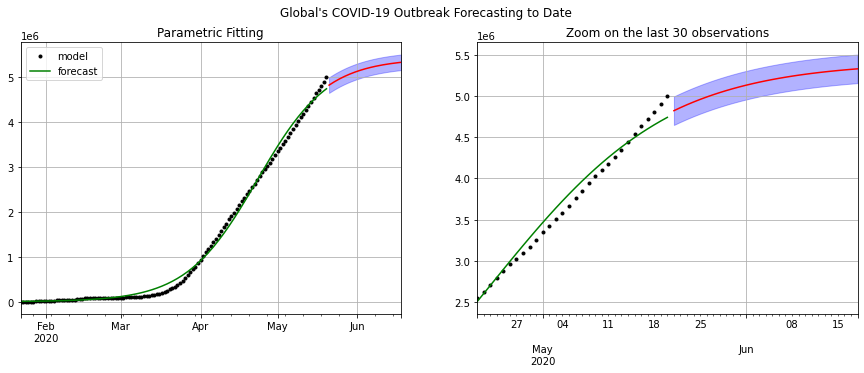

[5.41425065e+06 7.23795349e-02 9.20757994e+01]


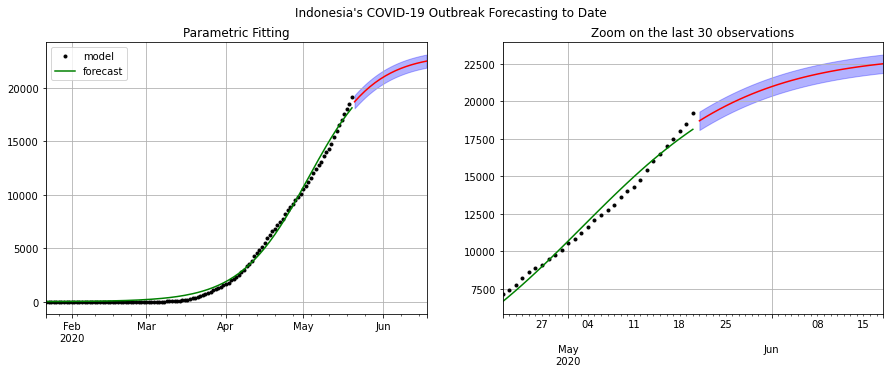

[2.31475765e+04 7.57198265e-02 1.02026795e+02]


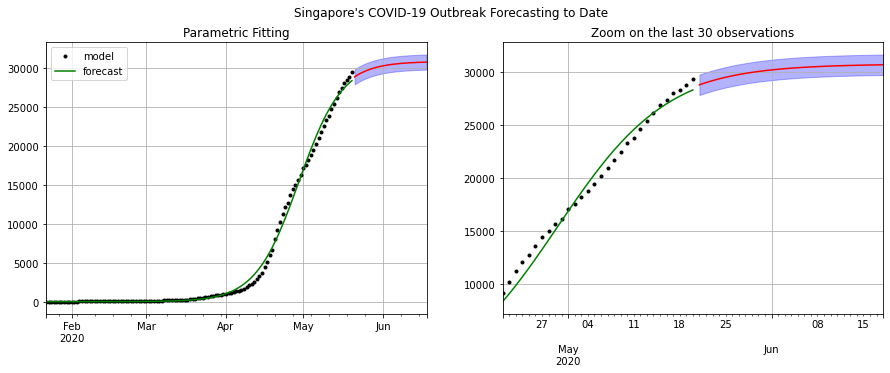

[3.07679077e+04 1.18607446e-01 9.83652507e+01]


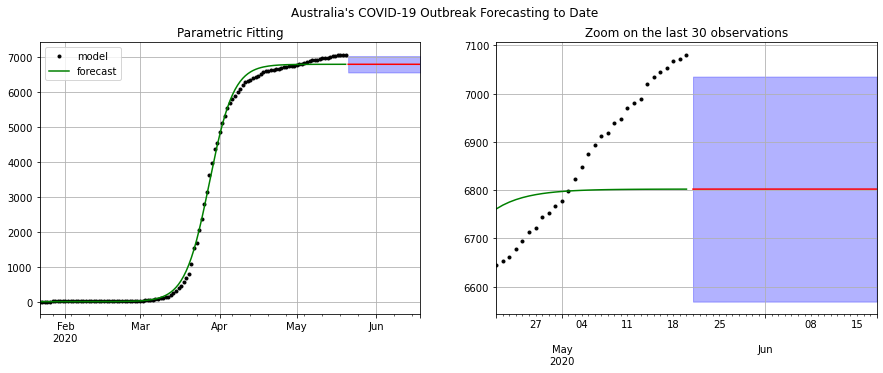

[6.80201584e+03 2.12392124e-01 6.59747692e+01]


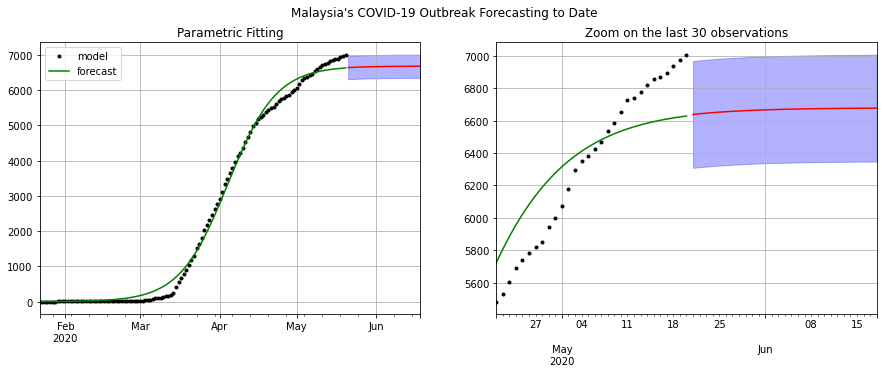

[6.67989732e+03 1.06457075e-01 7.32031454e+01]


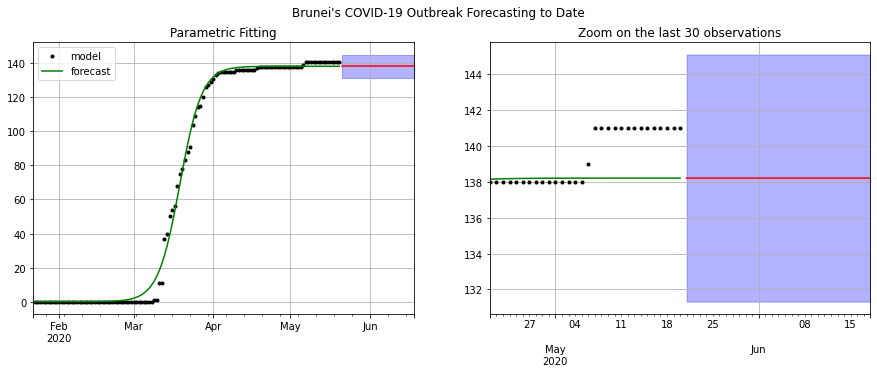

[138.20531221   0.23443427  57.02817205]


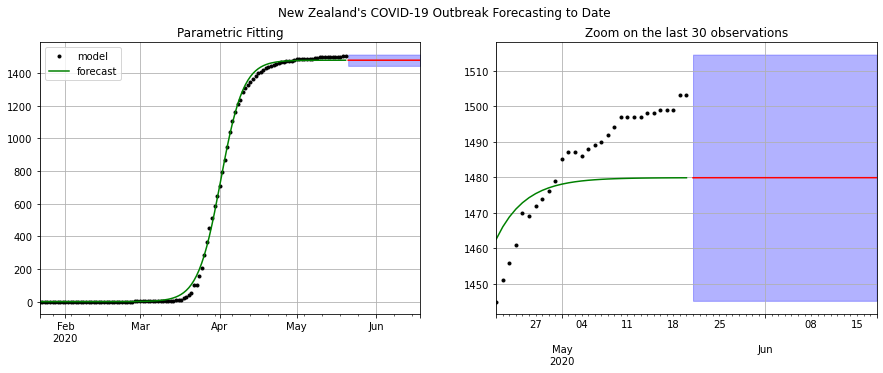

[1.47987184e+03 2.26117942e-01 7.03719130e+01]


In [18]:
# prediction result
print(predict('Global'))
print(predict('Indonesia'))
print(predict('Singapore'))
print(predict('Australia'))
print(predict('Malaysia'))
print(predict('Brunei'))
print(predict('New Zealand'))